In [1]:
import numpy as np
import pandas as pd
import os
import random

import lightgbm as lgb

import datetime
import jpholiday

In [2]:
input_path = '../datasets/'
target_category = [38, 110, 113, 114, 134, 171, 172, 173, 376, 435, 467, 537, 539, 629, 768]
target_category_str = [str(col) for col in target_category]

In [3]:
# log_df = pd.read_csv(os.path.join(input_path, 'carlog.csv'))
log_df2 = pd.read_csv('../output/cart_log.csv')
meta_df = pd.read_csv(os.path.join(input_path, 'meta.csv'), parse_dates=['date'])
test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))
product_master_df = pd.read_csv(os.path.join(input_path, 'product_master.csv'))
user_master_df = pd.read_csv(os.path.join(input_path, 'user_master.csv'))
# sample_submission_df = pd.read_csv(os.path.join(input_path, 'atmaCup#9__sample_submission.csv'))

train_Y = pd.read_csv('../output/train_Y.csv')
# test_Y = pd.read_csv('../output/test_Y.csv')

/Users/imazekishouta/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Feature Engineering
- 静的な情報はmeta_dfに集約させていく

## Date

In [4]:
def check_next_holiday(date):
    next_date = date + datetime.timedelta(days=1)
    
    is_jpholiday = jpholiday.is_holiday(next_date)
    if is_jpholiday or next_date.weekday() > 4:
        return 1
    else:
        return 0

date_df = meta_df[['date']].drop_duplicates().reset_index(drop=True)
date_df['month'] = [date.date().month for date in date_df.date]
date_df['day'] = [date.date().day for date in date_df.date]
date_df['weekday'] = [date.weekday() for date in date_df.date]
date_df['jp_holiday'] = [ jpholiday.is_holiday(date) for date in date_df['date']]
date_df.loc[date_df['weekday'] > 4, 'jp_holiday'] = True
date_df['jp_holiday'] = date_df['jp_holiday'].astype('int8')
date_df['tgif'] = [check_next_holiday(date.date()) for date in date_df.date]
date_df.loc[(date_df['jp_holiday']==1) & (date_df['tgif']==1), 'tgif'] = 0

date_df.head()

,date,month,day,weekday,jp_holiday,tgif
0,2019-02-14,2,14,3,0,0
1,2019-02-15,2,15,4,0,1
2,2019-02-16,2,16,5,1,0
3,2019-02-17,2,17,6,1,0
4,2019-02-18,2,18,0,0,0


In [5]:
meta_df = pd.merge(meta_df[['session_id', 'user_id', 'date', 'hour', 'register_number', 'time_elapsed']], date_df, on='date', how='left')
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,NaN,2,14,3,0,0
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,NaN,2,14,3,0,0
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,NaN,2,14,3,0,0
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,NaN,2,14,3,0,0
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,NaN,2,14,3,0,0


In [6]:
del date_df

## user_master

In [7]:
meta_df = pd.merge(meta_df, user_master_df, on='user_id', how='left')
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,NaN,2,14,3,0,0,40.0,1.0
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,NaN,2,14,3,0,0,30.0,0.0
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,NaN,2,14,3,0,0,50.0,1.0
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,NaN,2,14,3,0,0,30.0,0.0
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,NaN,2,14,3,0,0,30.0,1.0


In [8]:
del user_master_df

# 華金

In [9]:
meta_df['hanakin'] = 0
meta_df.loc[(meta_df['age']>=20) & (meta_df['tgif']==1) & (meta_df['hour'] >= 17), 'hanakin'] = 1
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,NaN,2,14,3,0,0,40.0,1.0,0
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,NaN,2,14,3,0,0,30.0,0.0,0
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,NaN,2,14,3,0,0,50.0,1.0,0
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,NaN,2,14,3,0,0,30.0,0.0,0
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,NaN,2,14,3,0,0,30.0,1.0,0


# 来店回数

In [10]:
meta_df['num_visit'] = meta_df[['session_id', 'user_id']].groupby('user_id').agg('cumcount')
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin,num_visit
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,NaN,2,14,3,0,0,40.0,1.0,0,0
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,NaN,2,14,3,0,0,30.0,0.0,0,0
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,NaN,2,14,3,0,0,50.0,1.0,0,0
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,NaN,2,14,3,0,0,30.0,0.0,0,0
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,NaN,2,14,3,0,0,30.0,1.0,0,0


## Max Elapsed_time

In [11]:
log_df2 = pd.read_csv('../output/cart_log.csv')
log_df2 = log_df2[log_df2['predict']==0]
max_time_df = log_df2.groupby('session_id')[['spend_time']].max().reset_index()

meta_df.loc[max_time_df['session_id'], 'time_elapsed'] = max_time_df['spend_time']
meta_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin,num_visit
0,0,bE94Gct4vGiKM7z2Y79cjk,2019-02-14,4,2003,140.0,2,14,3,0,0,40.0,1.0,0,0
1,1,V4bEuaKPEPoK8MswqPksvK,2019-02-14,4,2006,101.0,2,14,3,0,0,30.0,0.0,0,0
2,2,ntRurFKVWYBQR86auef5Fc,2019-02-14,5,2001,39.0,2,14,3,0,0,50.0,1.0,0,0
3,3,GhHaHMCyrz76y2dCeVXfbn,2019-02-14,5,2001,220.0,2,14,3,0,0,30.0,0.0,0,0
4,4,kG58HejrEcbjJQ7JojRSay,2019-02-14,5,2002,44.0,2,14,3,0,0,30.0,1.0,0,0


# meta情報の結合

In [12]:
train_df = pd.merge(train_Y[['session_id']], meta_df, on='session_id', how='left')
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin,num_visit
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,0,40.0,0.0,0,0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,0,60.0,1.0,0,0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,0,30.0,0.0,0,0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,0,60.0,0.0,0,0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,0,70.0,0.0,0,0


# 平均買い物時間

In [13]:
max_time_df = log_df2.groupby('session_id')[['spend_time']].max().reset_index()
max_time_df = pd.merge(max_time_df, meta_df[['session_id', 'user_id']], on='session_id', how='left')
max_time_df2 = max_time_df.copy()
max_time_df2['spend_time'] = max_time_df2.groupby('user_id')['spend_time'].shift()

cum = max_time_df2.groupby('user_id')['spend_time'].agg(['cumsum', 'cumcount'])

cum['avg'] = cum['cumsum'] / cum['cumcount']
max_time_df2['max_time_avg'] = cum['avg']
max_time_df2.fillna(-1, inplace=True)
max_time_df2.drop(['user_id', 'spend_time'], axis=1, inplace=True)
max_time_df2.head()

,session_id,max_time_avg
0,0,-1.0
1,1,-1.0
2,2,-1.0
3,3,-1.0
4,4,-1.0


## 結合

In [14]:
pre = len(train_df)
train_df = pd.merge(train_df, max_time_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin,num_visit,max_time_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,0,40.0,0.0,0,0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,0,60.0,1.0,0,0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,0,30.0,0.0,0,0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,0,60.0,0.0,0,0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,0,70.0,0.0,0,0,-1.0


In [15]:
del max_time_df2

# クーポン使用回数のラグ平均

In [16]:
all_qoupon_df = pd.read_csv('../output/all_qoupon.csv')


In [17]:
qoupon_col = 'num_qoupon'
all_qoupon_df2 = all_qoupon_df.copy()
all_qoupon_df2[qoupon_col] = all_qoupon_df2.groupby('user_id')[qoupon_col].shift()

cum = all_qoupon_df2.groupby('user_id')[qoupon_col].agg(['cumsum', 'cumcount'])
all_qoupon_df2['qoupon_avg'] = cum['cumsum']/ cum['cumcount']
target_qoupon_col = 'qoupon_avg'
all_qoupon_df2.drop(qoupon_col, axis=1, inplace=True)
# all_qoupon_df2.fillna(-1, inplace=True)
all_qoupon_df2.drop(['user_id'], axis=1, inplace=True)
all_qoupon_df2.head()

,session_id,qoupon_avg
0,63,NaN
1,105,NaN
2,107,NaN
3,108,NaN
4,109,NaN


In [18]:
pre = len(train_df)
train_df = pd.merge(train_df, all_qoupon_df2, on='session_id', how='left')
train_df[target_qoupon_col] = train_df[target_qoupon_col].fillna(-1)
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,tgif,age,gender,hanakin,num_visit,max_time_avg,qoupon_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,0,40.0,0.0,0,0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,0,60.0,1.0,0,0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,0,30.0,0.0,0,0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,0,60.0,0.0,0,0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,0,70.0,0.0,0,0,-1.0,-1.0


In [19]:
del all_qoupon_df2

# 関連カテゴリの購買

In [20]:
all_train_category = pd.read_csv('../output/all_train_category.csv')

In [21]:
categories_col = [col for col in all_train_category.columns if col != 'session_id']
all_train_category = pd.merge(all_train_category, meta_df[['session_id', 'user_id']], on='session_id', how='left')
all_train_category2 = all_train_category.copy()
all_train_category2[categories_col] = all_train_category2.groupby('user_id')[categories_col].shift()

cum = all_train_category2.groupby('user_id')[categories_col].agg(['cumsum', 'cumcount'])

cols = []

for col in categories_col:
    cols.append(col + '_cumsum')
    cols.append(col + '_cumcount')
cum.columns = cols

avg_categories_cols = []
for col in categories_col:
    k = col + '_avg'
#     cum[col + '_cumcount'] += 1
    all_train_category2[k]= cum[col + '_cumsum'] / cum[col + '_cumcount']
    avg_categories_cols.append(k)

all_train_category2.drop(categories_col, axis=1, inplace=True)
all_train_category2.fillna(-1, inplace=True)
all_train_category2.drop(['user_id'], axis=1, inplace=True)
all_train_category2.head()

,session_id,category_35_avg,category_37_avg,category_39_avg,category_40_avg,category_86_avg,category_111_avg,category_112_avg,category_135_avg,category_137_avg,...,category_679_avg,category_684_avg,category_708_avg,category_711_avg,category_716_avg,category_720_avg,category_724_avg,category_769_avg,category_770_avg,category_771_avg
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [22]:
pre = len(train_df)
train_df = pd.merge(train_df, all_train_category2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,category_679_avg,category_684_avg,category_708_avg,category_711_avg,category_716_avg,category_720_avg,category_724_avg,category_769_avg,category_770_avg,category_771_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [23]:
del all_train_category2

# word2vec特徴量のラグ平均

In [24]:
all_train_similar_category = pd.read_csv('../output/all_similar_category.csv')
all_train_similar_category.drop('index', axis=1, inplace=True)
all_train_similar_category.head()

,session_id,similar_110,similar_113,similar_114,similar_134,similar_171,similar_172,similar_173,similar_376,similar_38,similar_435,similar_467,similar_537,similar_539,similar_629,similar_768
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
similar_categories_col = [ 'similar_110', 'similar_113', 'similar_114',
       'similar_134', 'similar_171', 'similar_172', 'similar_173',
       'similar_376', 'similar_38', 'similar_435', 'similar_467',
       'similar_537', 'similar_539', 'similar_629', 'similar_768']

all_train_similar_category = pd.merge(all_train_similar_category, meta_df[['session_id', 'user_id']], on='session_id', how='left')
all_train_similar_category2 = all_train_similar_category.copy()
all_train_similar_category2[similar_categories_col] = all_train_similar_category2.groupby('user_id')[similar_categories_col].shift()

cum = all_train_similar_category2.groupby('user_id')[similar_categories_col].agg(['cumsum', 'cumcount'])

cols = []

for col in similar_categories_col:
    cols.append(col + '_cumsum')
    cols.append(col + '_cumcount')
cum.columns = cols

avg_similar_categories_cols = []
for col in similar_categories_col:
    k = col + '_avg'
#     cum[col + '_cumcount'] += 1
    all_train_similar_category2[k]= cum[col + '_cumsum'] / cum[col + '_cumcount']
    avg_categories_cols.append(k)

all_train_similar_category2.drop(similar_categories_col, axis=1, inplace=True)
all_train_similar_category2.fillna(-1, inplace=True)
all_train_similar_category2.drop(['user_id'], axis=1, inplace=True)
all_train_similar_category2.head()

,session_id,similar_110_avg,similar_113_avg,similar_114_avg,similar_134_avg,similar_171_avg,similar_172_avg,similar_173_avg,similar_376_avg,similar_38_avg,similar_435_avg,similar_467_avg,similar_537_avg,similar_539_avg,similar_629_avg,similar_768_avg
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [26]:
pre = len(train_df)
train_df = pd.merge(train_df, all_train_similar_category2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,similar_172_avg,similar_173_avg,similar_376_avg,similar_38_avg,similar_435_avg,similar_467_avg,similar_537_avg,similar_539_avg,similar_629_avg,similar_768_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [27]:
del all_train_similar_category2

# 過去の購買行動の情報を結合

In [28]:
all_train_Y = pd.read_csv('../output/all_train_Y.csv')

## 累積和を取って平均値を抽出

In [29]:
# cumsum
all_train_Y = pd.merge(all_train_Y, meta_df[['session_id', 'user_id']], on='session_id', how='left')
all_train_Y2 = all_train_Y.copy()
all_train_Y2[target_category_str] = all_train_Y2.groupby('user_id')[target_category_str].shift()

cum = all_train_Y2.groupby('user_id')[target_category_str].agg(['cumsum', 'cumcount'])

cols = []

for col in target_category_str:
    cols.append(col + '_cumsum')
    cols.append(col + '_cumcount')
cum.columns = cols

avg_cols = []
for col in target_category_str:
    k = col + '_avg'
#     cum[col + '_cumcount'] += 1
    all_train_Y2[k]= cum[col + '_cumsum'] / cum[col + '_cumcount']
    avg_cols.append(k)

all_train_Y2.drop(target_category_str, axis=1, inplace=True)
all_train_Y2.fillna(-1, inplace=True)
all_train_Y2.drop(['user_id'], axis=1, inplace=True)
all_train_Y2.head()

,index,session_id,38_avg,110_avg,113_avg,114_avg,134_avg,171_avg,172_avg,173_avg,376_avg,435_avg,467_avg,537_avg,539_avg,629_avg,768_avg
0,0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 結合

In [30]:
pre = len(train_df)
train_df = pd.merge(train_df, all_train_Y2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,171_avg,172_avg,173_avg,376_avg,435_avg,467_avg,537_avg,539_avg,629_avg,768_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [31]:
del all_train_Y2

## 対象カテゴリ外のラグ特徴量

In [32]:
all_train_depart_target_Y = pd.read_csv('../output/all_train_depart_target_Y.csv')
depart_target_str = list(all_train_depart_target_Y.columns)[1:]

## 累積和を取って平均値を抽出

In [33]:
# cumsum
all_train_depart_target_Y = pd.merge(all_train_depart_target_Y, meta_df[['session_id', 'user_id']], on='session_id', how='left')
all_train_depart_target_Y2 = all_train_depart_target_Y.copy()
all_train_depart_target_Y2[depart_target_str] = all_train_depart_target_Y2.groupby('user_id')[depart_target_str].shift()

cum = all_train_depart_target_Y2.groupby('user_id')[depart_target_str].agg(['cumsum', 'cumcount'])

cols = []
for col in depart_target_str:
    cols.append(col + '_cumsum')
    cols.append(col + '_cumcount')
cum.columns = cols

depart_avg_cols = []
for col in depart_target_str:
    k = col + '_depart_avg'
#     cum[col + '_cumcount'] += 1
    all_train_depart_target_Y2[k]= cum[col + '_cumsum'] / cum[col + '_cumcount']
    depart_avg_cols.append(k)

all_train_depart_target_Y2.drop(depart_target_str, axis=1, inplace=True)
all_train_depart_target_Y2.fillna(-1, inplace=True)
all_train_depart_target_Y2.drop(['user_id'], axis=1, inplace=True)
all_train_depart_target_Y2.head()

,session_id,1_depart_avg,2_depart_avg,3_depart_avg,4_depart_avg,5_depart_avg,7_depart_avg,9_depart_avg,10_depart_avg,13_depart_avg,...,225_depart_avg,226_depart_avg,227_depart_avg,228_depart_avg,229_depart_avg,230_depart_avg,231_depart_avg,232_depart_avg,233_depart_avg,234_depart_avg
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 結合

In [34]:
pre = len(train_df)
train_df = pd.merge(train_df, all_train_depart_target_Y2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,225_depart_avg,226_depart_avg,227_depart_avg,228_depart_avg,229_depart_avg,230_depart_avg,231_depart_avg,232_depart_avg,233_depart_avg,234_depart_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [35]:
del all_train_depart_target_Y2

# 過去の購入価格情報の結合

In [36]:
all_train_price = pd.read_csv('../output/all_train_price.csv')

## 累積和から平均を抽出

In [37]:
# cumsum
all_train_price = pd.merge(all_train_price, meta_df[['session_id', 'user_id']], on='session_id', how='left')
all_train_price2 = all_train_price.copy()
all_train_price2[target_category_str] = all_train_price2.groupby('user_id')[target_category_str].shift()

cum = all_train_price2.groupby('user_id')[target_category_str].agg(['cumsum', 'cumcount'])

cols = []

for col in target_category_str:
    cols.append(col + '_cumsum')
    cols.append(col + '_cumcount')
cum.columns = cols

price_avg_cols = []
for col in target_category_str:
    k = col + '_price_avg'
    all_train_price2[k]= cum[col + '_cumsum'] / cum[col + '_cumcount']
    price_avg_cols.append(k)

all_train_price2.drop(target_category_str, axis=1, inplace=True)
all_train_price2.fillna(-1, inplace=True)
all_train_price2.drop(['user_id'], axis=1, inplace=True)
all_train_price2.head()

,session_id,38_price_avg,110_price_avg,113_price_avg,114_price_avg,134_price_avg,171_price_avg,172_price_avg,173_price_avg,376_price_avg,435_price_avg,467_price_avg,537_price_avg,539_price_avg,629_price_avg,768_price_avg
0,0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## 結合

In [38]:
pre = len(train_df)
train_df = pd.merge(train_df, all_train_price2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,171_price_avg,172_price_avg,173_price_avg,376_price_avg,435_price_avg,467_price_avg,537_price_avg,539_price_avg,629_price_avg,768_price_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [39]:
del all_train_price2

# 子持ち特徴量

In [40]:
child_feature_df = pd.read_csv('../output/all_train_child_feature.csv')

## 累積和を元に平均を算出

In [41]:
# cumsum
child_col = 'child_items'
child_feature_df = pd.merge(child_feature_df, meta_df[['session_id', 'user_id']], on='session_id', how='left')
child_feature_df2 = child_feature_df.copy()
child_feature_df2[child_col] = child_feature_df2.groupby('user_id')[child_col].shift()

cum = child_feature_df2.groupby('user_id')[child_col].agg(['cumsum', 'cumcount'])

child_feature_df2['child_items_sum'] = cum['cumsum']
child_feature_df2['child_items_avg'] = cum['cumsum'] / cum['cumcount']
child_cols= ['child_items_sum', 'child_items_avg']
child_feature_df2.fillna(-1, inplace=True)
child_feature_df2.drop(['user_id', child_col], axis=1, inplace=True)
child_feature_df2.head()

,session_id,child_items_sum,child_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


## 結合

In [42]:
pre = len(train_df)
train_df = pd.merge(train_df, child_feature_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,173_price_avg,376_price_avg,435_price_avg,467_price_avg,537_price_avg,539_price_avg,629_price_avg,768_price_avg,child_items_sum,child_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [43]:
del child_feature_df2

# ひとり暮らし

In [44]:
alone_feature_df = pd.read_csv('../output/all_train_alone_feature.csv')

In [45]:
# cumsum
alone_col = 'alone_items'
alone_feature_df = pd.merge(alone_feature_df, meta_df[['session_id', 'user_id']], on='session_id', how='left')
alone_feature_df2 = alone_feature_df.copy()
alone_feature_df2[alone_col] = alone_feature_df2.groupby('user_id')[alone_col].shift()

cum = alone_feature_df2.groupby('user_id')[alone_col].agg(['cumsum', 'cumcount'])

alone_feature_df2['alone_items_sum'] = cum['cumsum']
alone_feature_df2['alone_items_avg'] = cum['cumsum'] / cum['cumcount']
alone_cols= ['alone_items_sum', 'alone_items_avg']
alone_feature_df2.fillna(-1, inplace=True)
alone_feature_df2.drop(['user_id', alone_col], axis=1, inplace=True)
alone_feature_df2.head()

,session_id,alone_items_sum,alone_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [46]:
pre = len(train_df)
train_df = pd.merge(train_df, alone_feature_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,435_price_avg,467_price_avg,537_price_avg,539_price_avg,629_price_avg,768_price_avg,child_items_sum,child_items_avg,alone_items_sum,alone_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [47]:
del alone_feature_df2

# お料理

In [48]:
cook_feature_df = pd.read_csv('../output/all_train_cook_feature.csv')

In [49]:
# cumsum
cook_col = 'cook_items'
cook_feature_df = pd.merge(cook_feature_df, meta_df[['session_id', 'user_id']], on='session_id', how='left')
cook_feature_df2 = cook_feature_df.copy()
cook_feature_df2[cook_col] = cook_feature_df2.groupby('user_id')[cook_col].shift()

cum = cook_feature_df2.groupby('user_id')[cook_col].agg(['cumsum', 'cumcount'])

cook_feature_df2['cook_items_sum'] = cum['cumsum']
cook_feature_df2['cook_items_avg'] = cum['cumsum'] / cum['cumcount']
cook_cols= ['cook_items_sum', 'cook_items_avg']
cook_feature_df2.fillna(-1, inplace=True)
cook_feature_df2.drop(['user_id', cook_col], axis=1, inplace=True)
cook_feature_df2.head()

,session_id,cook_items_sum,cook_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [50]:
pre = len(train_df)
train_df = pd.merge(train_df, cook_feature_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,537_price_avg,539_price_avg,629_price_avg,768_price_avg,child_items_sum,child_items_avg,alone_items_sum,alone_items_avg,cook_items_sum,cook_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [51]:
del cook_feature_df2

# キャンセル情報のラグ平均

In [52]:
cancel_df = pd.read_csv('../output/all_train_cancel.csv')
cancel_df.head()

,session_id,user_id,cancel
0,0,bE94Gct4vGiKM7z2Y79cjk,0
1,1,V4bEuaKPEPoK8MswqPksvK,0
2,2,ntRurFKVWYBQR86auef5Fc,0
3,3,GhHaHMCyrz76y2dCeVXfbn,0
4,4,kG58HejrEcbjJQ7JojRSay,0


In [53]:
# cumsum
cancel_col = 'cancel'
cancel_df2 = cancel_df.copy()
cancel_df2[cancel_col] = cancel_df2.groupby('user_id')[cancel_col].shift()

cum = cancel_df2.groupby('user_id')[cancel_col].agg(['cumsum', 'cumcount'])

cancel_df2['cancel_items_sum'] = cum['cumsum']
cancel_df2['cancel_items_avg'] = cum['cumsum'] / cum['cumcount']
cancel_cols= ['cancel_items_sum', 'cancel_items_avg']
cancel_df2.fillna(-1, inplace=True)
cancel_df2.drop(['user_id', cancel_col], axis=1, inplace=True)
cancel_df2.head()

,session_id,cancel_items_sum,cancel_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [54]:
pre = len(train_df)
train_df = pd.merge(train_df, cancel_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,629_price_avg,768_price_avg,child_items_sum,child_items_avg,alone_items_sum,alone_items_avg,cook_items_sum,cook_items_avg,cancel_items_sum,cancel_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [55]:
del cancel_df2

# 10分以降のキャンセル情報のラグ平均

In [56]:
cancel10_df = pd.read_csv('../output/all_train_10cancel.csv')
cancel10_df.head()

,session_id,user_id,cancel
0,0,bE94Gct4vGiKM7z2Y79cjk,0
1,1,V4bEuaKPEPoK8MswqPksvK,0
2,2,ntRurFKVWYBQR86auef5Fc,0
3,3,GhHaHMCyrz76y2dCeVXfbn,0
4,4,kG58HejrEcbjJQ7JojRSay,0


In [57]:
# cumsum
cancel_col = 'cancel'
cancel10_df2 = cancel10_df.copy()
cancel10_df2[cancel_col] = cancel10_df2.groupby('user_id')[cancel_col].shift()

cum = cancel10_df2.groupby('user_id')[cancel_col].agg(['cumsum', 'cumcount'])

cancel10_df2['cancel10_items_sum'] = cum['cumsum']
cancel10_df2['cancel10_items_avg'] = cum['cumsum'] / cum['cumcount']
cancel10_cols= ['cancel10_items_sum', 'cancel10_items_avg']
cancel10_df2.fillna(-1, inplace=True)
cancel10_df2.drop(['user_id', cancel_col], axis=1, inplace=True)
cancel10_df2.head()

,session_id,cancel10_items_sum,cancel10_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [58]:
pre = len(train_df)
train_df = pd.merge(train_df, cancel10_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,child_items_sum,child_items_avg,alone_items_sum,alone_items_avg,cook_items_sum,cook_items_avg,cancel_items_sum,cancel_items_avg,cancel10_items_sum,cancel10_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [59]:
del cancel10_df2

# 購入回数のラグ平均

In [60]:
buy_num_df = pd.read_csv('../output/all_train_buy_num.csv')
buy_num_df.head()

,session_id,user_id,n_items
0,0,bE94Gct4vGiKM7z2Y79cjk,5.0
1,1,V4bEuaKPEPoK8MswqPksvK,5.0
2,2,ntRurFKVWYBQR86auef5Fc,5.0
3,3,GhHaHMCyrz76y2dCeVXfbn,7.0
4,4,kG58HejrEcbjJQ7JojRSay,1.0


In [61]:
# cumsum
buy_num_col = 'n_items'
buy_num_df2 = buy_num_df.copy()
buy_num_df2[buy_num_col] = buy_num_df2.groupby('user_id')[buy_num_col].shift()

cum = buy_num_df2.groupby('user_id')[buy_num_col].agg(['cumsum', 'cumcount'])

buy_num_df2['buy_num_items_sum'] = cum['cumsum']
buy_num_df2['buy_num_items_avg'] = cum['cumsum'] / cum['cumcount']
buy_num_cols= ['buy_num_items_sum', 'buy_num_items_avg']
buy_num_df2.fillna(-1, inplace=True)
buy_num_df2.drop(['user_id', buy_num_col], axis=1, inplace=True)
buy_num_df2.head()

,session_id,buy_num_items_sum,buy_num_items_avg
0,0,-1.0,-1.0
1,1,-1.0,-1.0
2,2,-1.0,-1.0
3,3,-1.0,-1.0
4,4,-1.0,-1.0


In [62]:
pre = len(train_df)
train_df = pd.merge(train_df, buy_num_df2, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,alone_items_sum,alone_items_avg,cook_items_sum,cook_items_avg,cancel_items_sum,cancel_items_avg,cancel10_items_sum,cancel10_items_avg,buy_num_items_sum,buy_num_items_avg
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [63]:
del buy_num_df2

# 関連カテゴリの公開情報

In [64]:
def read_and_col_name(path='../output/given_train_category.csv'):
    df = pd.read_csv(path)
    cols = list(df.columns)
    rename_cols = []
    for col in cols:
        if col=='session_id':
            rename_cols.append(col)
        else:
            rename_cols.append(col + '_given')
    df.columns = rename_cols
    rename_cols.remove('session_id')
    return df, rename_cols

train_given_categories_df, given_categories_cols = read_and_col_name('../output/given_train_category.csv')
print(given_categories_cols)
train_given_categories_df.head()

['category_35_given', 'category_37_given', 'category_39_given', 'category_40_given', 'category_86_given', 'category_111_given', 'category_112_given', 'category_135_given', 'category_136_given', 'category_137_given', 'category_141_given', 'category_142_given', 'category_143_given', 'category_145_given', 'category_148_given', 'category_149_given', 'category_150_given', 'category_205_given', 'category_206_given', 'category_207_given', 'category_208_given', 'category_209_given', 'category_210_given', 'category_274_given', 'category_275_given', 'category_276_given', 'category_289_given', 'category_294_given', 'category_295_given', 'category_299_given', 'category_307_given', 'category_310_given', 'category_311_given', 'category_312_given', 'category_313_given', 'category_314_given', 'category_315_given', 'category_316_given', 'category_317_given', 'category_319_given', 'category_321_given', 'category_328_given', 'category_330_given', 'category_331_given', 'category_334_given', 'category_340_

,session_id,category_35_given,category_37_given,category_39_given,category_40_given,category_86_given,category_111_given,category_112_given,category_135_given,category_136_given,...,category_708_given,category_711_given,category_716_given,category_720_given,category_724_given,category_726_given,category_756_given,category_769_given,category_770_given,category_771_given
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
pre = len(train_df)
train_df = pd.merge(train_df, train_given_categories_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,category_708_given,category_711_given,category_716_given,category_720_given,category_724_given,category_726_given,category_756_given,category_769_given,category_770_given,category_771_given
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# word2vecの公開情報

In [66]:
def read_and_col_name(path='../output/given_train_similar_category.csv'):
    df = pd.read_csv(path)
    df.drop('index', axis=1, inplace=True)
    cols = list(df.columns)
    rename_cols = []
    for col in cols:
        if col=='session_id' or col=='index':
            rename_cols.append(col)
        else:
            rename_cols.append(col + '_given')
    df.columns = rename_cols
    rename_cols.remove('session_id')
    return df, rename_cols

train_given_similar_categories_df, given_similar_categories_cols = read_and_col_name('../output/given_train_similar_category.csv')
print(given_similar_categories_cols)
train_given_similar_categories_df.head()

['similar_110_given', 'similar_113_given', 'similar_114_given', 'similar_134_given', 'similar_171_given', 'similar_172_given', 'similar_173_given', 'similar_376_given', 'similar_38_given', 'similar_435_given', 'similar_467_given', 'similar_537_given', 'similar_539_given', 'similar_629_given', 'similar_768_given']


,session_id,similar_110_given,similar_113_given,similar_114_given,similar_134_given,similar_171_given,similar_172_given,similar_173_given,similar_376_given,similar_38_given,similar_435_given,similar_467_given,similar_537_given,similar_539_given,similar_629_given,similar_768_given
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
pre = len(train_df)
train_df = pd.merge(train_df, train_given_similar_categories_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,similar_172_given,similar_173_given,similar_376_given,similar_38_given,similar_435_given,similar_467_given,similar_537_given,similar_539_given,similar_629_given,similar_768_given
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 対象セッションの公開情報の結合

## 結合カラムの名前変更

In [68]:
def read_and_col_name(path='../output/train_given.csv'):
    df = pd.read_csv(path)
    cols = list(df.columns)
    rename_cols = []
    for col in cols:
        if col=='session_id':
            rename_cols.append(col)
        else:
            rename_cols.append(col + '_given')
    df.columns = rename_cols
    rename_cols.remove('session_id')
    return df, rename_cols

train_given_df, given_cols = read_and_col_name('../output/train_given.csv')
print(given_cols)
train_given_df.head()

['38_given', '110_given', '113_given', '114_given', '134_given', '171_given', '172_given', '173_given', '376_given', '435_given', '467_given', '537_given', '539_given', '629_given', '768_given']


,session_id,38_given,110_given,113_given,114_given,134_given,171_given,172_given,173_given,376_given,435_given,467_given,537_given,539_given,629_given,768_given
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
pre = len(train_df)
train_df = pd.merge(train_df, train_given_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,171_given,172_given,173_given,376_given,435_given,467_given,537_given,539_given,629_given,768_given
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 対象セッションの公開情報(子供特徴量)

In [70]:
def read_child(path='../output/given_train_child_feature.csv'):
    df = pd.read_csv(path)
#     df.columns = rename_cols
#     rename_cols.remove('session_id')
    return df, ['child_items']

train_child_given_df, given_child_cols = read_child('../output/given_train_child_feature.csv')
print(given_child_cols)
train_child_given_df.head()

['child_items']


,session_id,child_items
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [71]:
pre = len(train_df)
train_df = pd.merge(train_df, train_child_given_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,172_given,173_given,376_given,435_given,467_given,537_given,539_given,629_given,768_given,child_items
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 対象セッションの公開情報(ひとり暮らし特徴量)

In [72]:
def read_alone(path='../output/given_train_alone_feature.csv'):
    df = pd.read_csv(path)
#     df.columns = rename_cols
#     rename_cols.remove('session_id')
    return df, ['alone_items']

train_alone_given_df, given_alone_cols = read_alone('../output/given_train_alone_feature.csv')
print(given_alone_cols)
train_alone_given_df.head()

['alone_items']


,session_id,alone_items
0,0,5.0
1,1,0.0
2,2,2.0
3,3,1.0
4,4,0.0


In [73]:
pre = len(train_df)
train_df = pd.merge(train_df, train_alone_given_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,173_given,376_given,435_given,467_given,537_given,539_given,629_given,768_given,child_items,alone_items
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 対象セッションの公開情報(お料理特徴量)

In [74]:
def read_cook(path='../output/given_train_cook_feature.csv'):
    df = pd.read_csv(path)
#     df.columns = rename_cols
#     rename_cols.remove('session_id')
    return df, ['cook_items']

train_cook_given_df, given_cook_cols = read_cook('../output/given_train_cook_feature.csv')
print(given_cook_cols)
train_cook_given_df.head()

['cook_items']


,session_id,cook_items
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


In [75]:
pre = len(train_df)
train_df = pd.merge(train_df, train_cook_given_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,376_given,435_given,467_given,537_given,539_given,629_given,768_given,child_items,alone_items,cook_items
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


## 対象セッションでの購入数(公開情報)

In [76]:
def read_child(path='../output/given_train_buy_num.csv'):
    df = pd.read_csv(path)
    df.columns = ['session_id', 'user_id', 'given_buy_num']
    return df, ['given_buy_num']
train_buy_num_given_df, given_buy_num_cols = read_child('../output/given_train_buy_num.csv')
print(given_buy_num_cols)
train_buy_num_given_df.head()

['given_buy_num']


,session_id,user_id,given_buy_num
0,0,bE94Gct4vGiKM7z2Y79cjk,5.0
1,1,V4bEuaKPEPoK8MswqPksvK,5.0
2,2,ntRurFKVWYBQR86auef5Fc,5.0
3,3,GhHaHMCyrz76y2dCeVXfbn,7.0
4,4,kG58HejrEcbjJQ7JojRSay,1.0


In [77]:
pre = len(train_df)
train_df = pd.merge(train_df, train_buy_num_given_df, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()

,session_id,user_id_x,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,467_given,537_given,539_given,629_given,768_given,child_items,alone_items,cook_items,user_id_y,given_buy_num
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CN9sWHXp6RdCuyFkW5aemG,3.0
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wi5hmLRCmUPXMRheu354dd,2.0
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,kTFrFDLeaaggCoubWZJHpg,1.0
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,exwdBc8tNJYAjhc4Gd6qtj,4.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,XUeiScqGsozKQFxcd3RDsD,2.0


# クーポン公開情報

In [78]:
train_given_qoupon = pd.read_csv('../output/given_qoupon.csv')[['session_id', 'num_qoupon']]
avg_qoupon = 'avg_qoupon'
train_given_qoupon.columns = ['session_id', avg_qoupon]

In [79]:
pre = len(train_df)
train_df = pd.merge(train_df, train_given_qoupon, on='session_id', how='left')
assert pre == len(train_df)
train_df.head()


,session_id,user_id_x,date,hour,register_number,time_elapsed,month,day,weekday,jp_holiday,...,537_given,539_given,629_given,768_given,child_items,alone_items,cook_items,user_id_y,given_buy_num,avg_qoupon
0,105,CN9sWHXp6RdCuyFkW5aemG,2019-02-14,9,1005,152.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CN9sWHXp6RdCuyFkW5aemG,3.0,NaN
1,106,Wi5hmLRCmUPXMRheu354dd,2019-02-14,9,1010,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wi5hmLRCmUPXMRheu354dd,2.0,NaN
2,107,kTFrFDLeaaggCoubWZJHpg,2019-02-14,9,1010,177.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,kTFrFDLeaaggCoubWZJHpg,1.0,NaN
3,108,exwdBc8tNJYAjhc4Gd6qtj,2019-02-14,9,1011,247.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,1.0,2.0,exwdBc8tNJYAjhc4Gd6qtj,4.0,1.0
4,109,XUeiScqGsozKQFxcd3RDsD,2019-02-14,9,1013,147.0,2,14,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,XUeiScqGsozKQFxcd3RDsD,2.0,1.0


 # 特徴量選択

In [80]:
add_cols = avg_cols + given_cols + price_avg_cols  + child_cols + given_child_cols + depart_avg_cols + cancel_cols   + buy_num_cols + given_buy_num_cols + cancel10_cols + alone_cols  + given_alone_cols + cook_cols + given_cook_cols + [target_qoupon_col] + [avg_qoupon] + avg_categories_cols + given_categories_cols + avg_similar_categories_cols  + given_similar_categories_cols         
feature_cols = ['age', 'gender', 'hour', 'weekday', 'jp_holiday', 'tgif', 'num_visit', 'month', 'day', 'register_number', 'max_time_avg', 'time_elapsed', 'hanakin']  + add_cols
# feature_cols = ['age', 'gender', 'hour', 'weekday', 'jp_holiday', 'tgif', 'num_visit', 'month', 'day', 'register_number', 'max_time_avg', 'time_elapsed']  + add_cols
# 

categorical_columns =  ['gender', 'weekday', 'jp_holiday', 'tgif', 'month', 'day', 'register_number', 'hanakin']
# categorical_columns =  ['gender', 'weekday', 'jp_holiday', 'tgif', 'month', 'day', 'register_number']

print(feature_cols)

['age', 'gender', 'hour', 'weekday', 'jp_holiday', 'tgif', 'num_visit', 'month', 'day', 'register_number', 'max_time_avg', 'time_elapsed', 'hanakin', '38_avg', '110_avg', '113_avg', '114_avg', '134_avg', '171_avg', '172_avg', '173_avg', '376_avg', '435_avg', '467_avg', '537_avg', '539_avg', '629_avg', '768_avg', '38_given', '110_given', '113_given', '114_given', '134_given', '171_given', '172_given', '173_given', '376_given', '435_given', '467_given', '537_given', '539_given', '629_given', '768_given', '38_price_avg', '110_price_avg', '113_price_avg', '114_price_avg', '134_price_avg', '171_price_avg', '172_price_avg', '173_price_avg', '376_price_avg', '435_price_avg', '467_price_avg', '537_price_avg', '539_price_avg', '629_price_avg', '768_price_avg', 'child_items_sum', 'child_items_avg', 'child_items', '1_depart_avg', '2_depart_avg', '3_depart_avg', '4_depart_avg', '5_depart_avg', '7_depart_avg', '9_depart_avg', '10_depart_avg', '13_depart_avg', '14_depart_avg', '15_depart_avg', '16_d

In [81]:
train_Y.tail()

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768
404820,663697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404821,663698,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404822,663699,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
404823,663702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
404824,663705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
train_df.to_csv('../output/train_df.csv', index=None)

# Train

In [196]:
SEED = 5 # 1,2,3,4,5

In [197]:
params = {
'num_leaves': 300,
'max_bin':450,
'feature_fraction': 0.52,
'bagging_fraction': 0.52,
'objective': 'binary',
'learning_rate': 0.05,
"boosting_type": "gbdt",
"metric": 'auc',
'random_state': SEED
}

In [198]:
models = []
best_cv_scores = {}
best_model_scores = {}

for target_col in target_category_str:
    print('*'*100)
    print('*'*100)
    true_ids = list(train_Y[train_Y[target_col]==1].session_id.unique())
    false_ids = list(train_Y[train_Y[target_col]!=1].session_id.unique())
    print(target_col, len(true_ids), len(false_ids))
    
    false_ids = random.sample(false_ids, len(true_ids) * 2) # down samplling
    sampling_ids = true_ids + false_ids
    sampling_ids = sorted(sampling_ids)
    
    train_idx = sampling_ids[: int(len(sampling_ids)*0.8)]
    val_idx = sampling_ids[int(len(sampling_ids)*0.8): ]
    
    assert set(train_idx) & set(val_idx) == set()
    train_X = train_df[train_df.session_id.isin(train_idx)]
    train_y = train_Y[train_Y.session_id.isin(train_idx)]

    valid_X = train_df[train_df.session_id.isin(val_idx)].reset_index()
    valid_y = train_Y[train_Y.session_id.isin(val_idx)].reset_index()
    print('train & valid: ', len(train_X), len(valid_X))
    
    
    tr_data = lgb.Dataset(train_X[feature_cols], label=train_y[target_col], feature_name=feature_cols)
    va_data = lgb.Dataset(valid_X[feature_cols], label=valid_y[target_col], feature_name=feature_cols)
    del train_X, train_y, valid_X, valid_y
    
    cv = lgb.train(
        params, 
        tr_data,
        num_boost_round=5000,
        valid_sets=[tr_data, va_data],
        early_stopping_rounds=50,
        feature_name=feature_cols,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    
    score = cv.best_score['valid_1']['auc']
    best_cv_scores[target_col] = score
    
    print('-'*100)
    all_train_X = train_df[train_df.session_id.isin(sampling_ids)]
    all_train_y = train_Y[train_Y.session_id.isin(sampling_ids)]
    all_tr_data = lgb.Dataset(all_train_X[feature_cols], label=all_train_y[target_col], feature_name=feature_cols)
    model = lgb.train(
        params, 
        tr_data,
        num_boost_round=cv.current_iteration(),
        valid_sets=[all_tr_data],
        early_stopping_rounds=50,
        feature_name=feature_cols,
        categorical_feature=categorical_columns,
        verbose_eval=50
    )
    score = model.best_score['valid_0']['auc']
    best_model_scores[target_col] = score
    
    
     # _ = lgb.plot_importance(model)
    models.append(model)
#     del tr_data, va_data

****************************************************************************************************
****************************************************************************************************
38 30544 374281
train & valid:  73305 18327
[LightGBM] [Info] Number of positive: 23406, number of negative: 49899
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.199768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126879
[LightGBM] [Info] Number of data points in the train set: 73305, number of used features: 494
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.319296 -> initscore=-0.757009
[LightGBM] [Info] Start training from score -0.757009
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.927622	valid_1's auc: 0.785534
[100]	training's auc: 0.971366	valid_1's auc: 0.78657
Early stopping, best iteration is:
[82]	training's auc: 0.957893	valid_1's auc: 0.786

[50]	training's auc: 0.855624	valid_1's auc: 0.729376
Early stopping, best iteration is:
[17]	training's auc: 0.79888	valid_1's auc: 0.730705
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 43245, number of negative: 86451
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 130077
[LightGBM] [Info] Number of data points in the train set: 129696, number of used features: 501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333434 -> initscore=-0.692696
[LightGBM] [Info] Start training from score -0.692696
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[17]	valid_0's auc: 0.784465
****************************************************************************************************
*****************

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.331470 -> initscore=-0.701542
[LightGBM] [Info] Start training from score -0.701542
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.863924
Did not meet early stopping. Best iteration is:
[74]	valid_0's auc: 0.891537
****************************************************************************************************
****************************************************************************************************
435 18991 385834
train & valid:  45578 11395
[LightGBM] [Info] Number of positive: 15038, number of negative: 30540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 122654
[LightGBM] [Info] Number of data points in the train set: 45578, number of used features: 490
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.329940 -> initscore=-0.708457
[Light

[50]	training's auc: 0.998662	valid_1's auc: 0.907626
[100]	training's auc: 0.999997	valid_1's auc: 0.908812
[150]	training's auc: 1	valid_1's auc: 0.908707
Early stopping, best iteration is:
[106]	training's auc: 0.999997	valid_1's auc: 0.90938
----------------------------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 3353, number of negative: 6415
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103454
[LightGBM] [Info] Number of data points in the train set: 9768, number of used features: 451
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.343264 -> initscore=-0.648784
[LightGBM] [Info] Start training from score -0.648784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 

In [199]:
cv_scores = []
model_scores = []
for k, k2 in zip(best_cv_scores.keys(), best_model_scores.keys()):
    category_name = product_master_df[product_master_df.category_id==int(k)]['category_name'].values[0]
    cv_scores.append(best_cv_scores[k])
    model_scores.append(best_model_scores[k2])
    print(f'{k}({category_name}): cv: {best_cv_scores[k]}, model: {best_model_scores[k2]}')
print('cv: ', sum(cv_scores) / len(cv_scores))
print('model: ', sum(model_scores) / len(model_scores))

38(アイスクリーム__ノベルティー): cv: 0.7868289403636908, model: 0.9269208783592189
110(スナック・キャンディー__ガム): cv: 0.7894953591031483, model: 0.9731535746157056
113(スナック・キャンディー__シリアル): cv: 0.7851935545420874, model: 0.9778151790353435
114(スナック・キャンディー__スナック): cv: 0.7531768737414665, model: 0.8601934579596107
134(チョコ・ビスクラ__チョコレート): cv: 0.7307054235227175, model: 0.7844649257978984
171(ビール系__RTD): cv: 0.8479526751198937, model: 0.9636007035792457
172(ビール系__ノンアルコール): cv: 0.8738085122064364, model: 0.9864348484640952
173(ビール系__ビール系): cv: 0.850610803052238, model: 0.9522707199732625
376(和菓子__米菓): cv: 0.7465642174665833, model: 0.8915373513669802
435(大型PET__無糖茶（大型PET）): cv: 0.8592790401433451, model: 0.9624064315641939
467(小型PET__コーヒー（小型PET）): cv: 0.8510543618511358, model: 0.9668747935041542
537(水・炭酸水__大型PET（炭酸水）): cv: 0.8741614843975327, model: 0.9795804248144518
539(水・炭酸水__小型PET（炭酸水）): cv: 0.8288167083461793, model: 0.9733012971348443
629(缶飲料__コーヒー（缶）): cv: 0.9093800658945284, model: 0.9868774939782311
768(

In [200]:
# importance = pd.DataFrame(model.feature_importance(), index=feature_cols, columns=['importance'])
# importance.sort_values('importance', ascending=False)

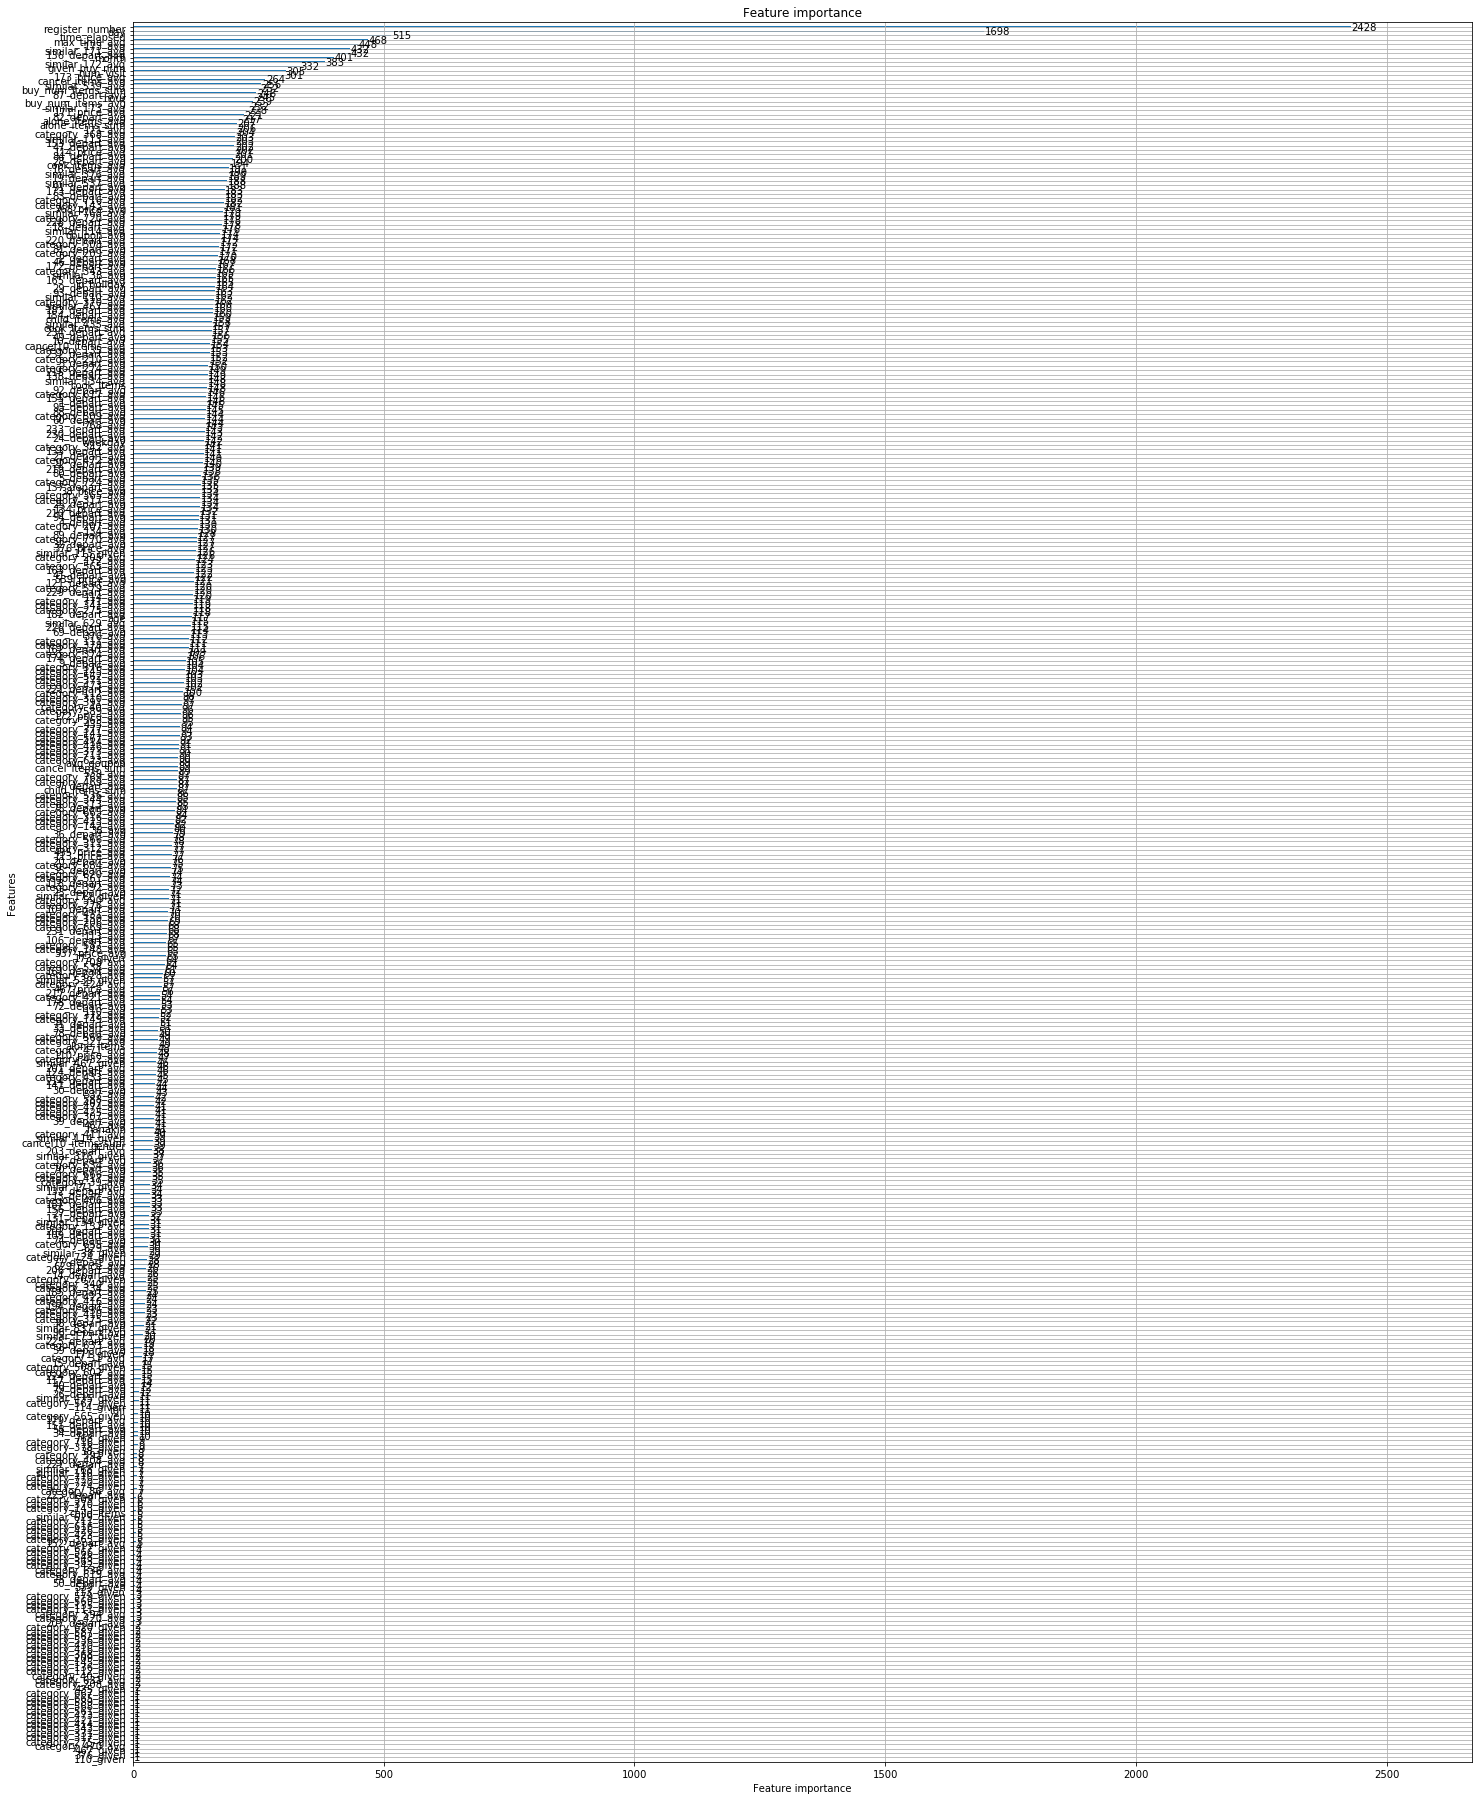

In [201]:
_ = lgb.plot_importance(models[7], figsize=(24,32))

# Inference

In [202]:
all_qoupon_df.head()

,session_id,num_qoupon,user_id
0,63,1,4x6SEeZU89iakENbrPRr9Y
1,105,1,CN9sWHXp6RdCuyFkW5aemG
2,107,3,kTFrFDLeaaggCoubWZJHpg
3,108,2,exwdBc8tNJYAjhc4Gd6qtj
4,109,1,XUeiScqGsozKQFxcd3RDsD


In [203]:
qoupon_agg = all_qoupon_df.groupby('user_id')[['num_qoupon']].agg(['sum']).reset_index()
qoupon_agg.columns = ['user_id'] + [target_qoupon_col]
qoupon_agg = pd.merge(qoupon_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
qoupon_agg.head()

,user_id,qoupon_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,10,4498
1,222BJXjf8z6YfvHVLvjbhK,10,13033
2,222BJXjf8z6YfvHVLvjbhK,10,30288
3,222BJXjf8z6YfvHVLvjbhK,10,42768
4,222BJXjf8z6YfvHVLvjbhK,10,45908


In [204]:
buy_num_agg = buy_num_df.groupby('user_id')[['n_items']].agg(['sum', 'mean']).reset_index()
buy_num_agg.columns = ['user_id'] + buy_num_cols
buy_num_agg = pd.merge(buy_num_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
buy_num_agg.head()

,user_id,buy_num_items_sum,buy_num_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,149.0,18.625,4498
1,222BJXjf8z6YfvHVLvjbhK,149.0,18.625,13033
2,222BJXjf8z6YfvHVLvjbhK,149.0,18.625,30288
3,222BJXjf8z6YfvHVLvjbhK,149.0,18.625,42768
4,222BJXjf8z6YfvHVLvjbhK,149.0,18.625,45908


In [205]:
cancel_agg = cancel_df.groupby('user_id')[['cancel']].agg(['sum', 'mean']).reset_index()
cancel_agg.columns = ['user_id'] + cancel_cols
cancel_agg = pd.merge(cancel_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
cancel_agg.head()

,user_id,cancel_items_sum,cancel_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0,0.0,4498
1,222BJXjf8z6YfvHVLvjbhK,0,0.0,13033
2,222BJXjf8z6YfvHVLvjbhK,0,0.0,30288
3,222BJXjf8z6YfvHVLvjbhK,0,0.0,42768
4,222BJXjf8z6YfvHVLvjbhK,0,0.0,45908


In [206]:
cancel10_agg = cancel10_df.groupby('user_id')[['cancel']].agg(['sum', 'mean']).reset_index()
cancel10_agg.columns = ['user_id'] + cancel_cols
cancel10_agg = pd.merge(cancel10_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
cancel10_agg.columns = ['user_id', 'cancel10_items_sum', 'cancel10_items_avg', 'session_id']
cancel10_agg.head()

,user_id,cancel10_items_sum,cancel10_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0,0.0,4498
1,222BJXjf8z6YfvHVLvjbhK,0,0.0,13033
2,222BJXjf8z6YfvHVLvjbhK,0,0.0,30288
3,222BJXjf8z6YfvHVLvjbhK,0,0.0,42768
4,222BJXjf8z6YfvHVLvjbhK,0,0.0,45908


In [207]:
max_time_agg = max_time_df.groupby('user_id')[['spend_time']].mean().reset_index()
max_time_agg = pd.merge(max_time_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
max_time_agg = max_time_agg[['session_id', 'spend_time']]
max_time_agg.columns = ['session_id', 'max_time_avg']
max_time_agg.head()

,session_id,max_time_avg
0,4498,189.0
1,13033,189.0
2,30288,189.0
3,42768,189.0
4,45908,189.0


In [208]:
similar_categories_agg = all_train_similar_category.groupby('user_id')[similar_categories_col].agg(['sum', 'count'])

cols = []
for col in similar_categories_col:
    cols.append(col + '_sum')
    cols.append(col + '_count')
similar_categories_agg.columns = cols

for col in similar_categories_col:
    k = col + '_avg'
    similar_categories_agg[k]= similar_categories_agg[col + '_sum'] / similar_categories_agg[col + '_count']
    similar_categories_agg.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

similar_categories_agg = similar_categories_agg.reset_index()

similar_categories_agg = pd.merge(similar_categories_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

similar_categories_agg.head()

,user_id,similar_110_avg,similar_113_avg,similar_114_avg,similar_134_avg,similar_171_avg,similar_172_avg,similar_173_avg,similar_376_avg,similar_38_avg,similar_435_avg,similar_467_avg,similar_537_avg,similar_539_avg,similar_629_avg,similar_768_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.0,0.875,0.625,0.0,0.5,0.5,0.375,0.5,0.375,0.5,0.25,0.875,1.625,0.0,0.5,4498
1,222BJXjf8z6YfvHVLvjbhK,0.0,0.875,0.625,0.0,0.5,0.5,0.375,0.5,0.375,0.5,0.25,0.875,1.625,0.0,0.5,13033
2,222BJXjf8z6YfvHVLvjbhK,0.0,0.875,0.625,0.0,0.5,0.5,0.375,0.5,0.375,0.5,0.25,0.875,1.625,0.0,0.5,30288
3,222BJXjf8z6YfvHVLvjbhK,0.0,0.875,0.625,0.0,0.5,0.5,0.375,0.5,0.375,0.5,0.25,0.875,1.625,0.0,0.5,42768
4,222BJXjf8z6YfvHVLvjbhK,0.0,0.875,0.625,0.0,0.5,0.5,0.375,0.5,0.375,0.5,0.25,0.875,1.625,0.0,0.5,45908


In [209]:
categories_agg = all_train_category.groupby('user_id')[categories_col].agg(['sum', 'count'])

cols = []
for col in categories_col:
    cols.append(col + '_sum')
    cols.append(col + '_count')
categories_agg.columns = cols

for col in categories_col:
    k = col + '_avg'
    categories_agg[k]= categories_agg[col + '_sum'] / categories_agg[col + '_count']
    categories_agg.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

categories_agg = categories_agg.reset_index()

categories_agg = pd.merge(categories_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

categories_agg.head()


,user_id,category_35_avg,category_37_avg,category_39_avg,category_40_avg,category_86_avg,category_111_avg,category_112_avg,category_135_avg,category_137_avg,...,category_684_avg,category_708_avg,category_711_avg,category_716_avg,category_720_avg,category_724_avg,category_769_avg,category_770_avg,category_771_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.25,0.0,0.25,0.125,0.0,0.25,4498
1,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.25,0.0,0.25,0.125,0.0,0.25,13033
2,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.25,0.0,0.25,0.125,0.0,0.25,30288
3,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.25,0.0,0.25,0.125,0.0,0.25,42768
4,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.125,0.25,0.0,0.25,0.125,0.0,0.25,45908


In [210]:
# make feature
agg = all_train_Y.groupby('user_id')[target_category_str].agg(['sum', 'count'])

cols = []
for col in target_category_str:
    cols.append(col + '_sum')
    cols.append(col + '_count')
agg.columns = cols

for col in target_category_str:
    k = col + '_avg'
    agg[k]= agg[col + '_sum'] / agg[col + '_count']
    agg.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

agg = agg.reset_index()

agg = pd.merge(agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

agg.head()

,user_id,38_avg,110_avg,113_avg,114_avg,134_avg,171_avg,172_avg,173_avg,376_avg,435_avg,467_avg,537_avg,539_avg,629_avg,768_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.375,0.0,0.0,0.0,0.625,0.0,0.0,0.125,4498
1,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.375,0.0,0.0,0.0,0.625,0.0,0.0,0.125,13033
2,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.375,0.0,0.0,0.0,0.625,0.0,0.0,0.125,30288
3,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.375,0.0,0.0,0.0,0.625,0.0,0.0,0.125,42768
4,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.375,0.0,0.0,0.0,0.625,0.0,0.0,0.125,45908


In [211]:
# make feature
depart_agg = all_train_depart_target_Y.groupby('user_id')[depart_target_str].agg(['sum', 'count'])

cols = []
for col in depart_target_str:
    cols.append(col + '_sum')
    cols.append(col + '_count')
depart_agg.columns = cols

for col in depart_target_str:
    k = col + '_depart_avg'
    depart_agg[k]= depart_agg[col + '_sum'] / depart_agg[col + '_count']
    depart_agg.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

depart_agg = depart_agg.reset_index()
depart_agg = pd.merge(depart_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')
depart_agg.head()

,user_id,1_depart_avg,2_depart_avg,3_depart_avg,4_depart_avg,5_depart_avg,7_depart_avg,9_depart_avg,10_depart_avg,13_depart_avg,...,226_depart_avg,227_depart_avg,228_depart_avg,229_depart_avg,230_depart_avg,231_depart_avg,232_depart_avg,233_depart_avg,234_depart_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.125,0.125,0.625,0.125,0.25,0.0,0.125,0.0,0.0,...,0.125,0.0,0.25,0.0,0.25,0.0,0.0,0.625,0.0,4498
1,222BJXjf8z6YfvHVLvjbhK,0.125,0.125,0.625,0.125,0.25,0.0,0.125,0.0,0.0,...,0.125,0.0,0.25,0.0,0.25,0.0,0.0,0.625,0.0,13033
2,222BJXjf8z6YfvHVLvjbhK,0.125,0.125,0.625,0.125,0.25,0.0,0.125,0.0,0.0,...,0.125,0.0,0.25,0.0,0.25,0.0,0.0,0.625,0.0,30288
3,222BJXjf8z6YfvHVLvjbhK,0.125,0.125,0.625,0.125,0.25,0.0,0.125,0.0,0.0,...,0.125,0.0,0.25,0.0,0.25,0.0,0.0,0.625,0.0,42768
4,222BJXjf8z6YfvHVLvjbhK,0.125,0.125,0.625,0.125,0.25,0.0,0.125,0.0,0.0,...,0.125,0.0,0.25,0.0,0.25,0.0,0.0,0.625,0.0,45908


In [212]:
# make feature
agg2 = all_train_price.groupby('user_id')[target_category_str].agg(['sum', 'count'])

cols = []
for col in target_category_str:
    cols.append(col + '_sum')
    cols.append(col + '_count')
agg2.columns = cols

for col in target_category_str:
    k = col + '_price_avg'
    agg2[k]= agg2[col + '_sum'] / agg2[col + '_count']
    agg2.drop([col + '_sum', col + '_count'], axis=1, inplace=True)

agg2 = agg2.reset_index()
agg2 = pd.merge(agg2, meta_df[['session_id', 'user_id']], on='user_id', how='left')
agg2.head()

,user_id,38_price_avg,110_price_avg,113_price_avg,114_price_avg,134_price_avg,171_price_avg,172_price_avg,173_price_avg,376_price_avg,435_price_avg,467_price_avg,537_price_avg,539_price_avg,629_price_avg,768_price_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,12.5,0.0,172.375,0.0,0.0,0.0,61.625,0.0,0.0,52.0,4498
1,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,12.5,0.0,172.375,0.0,0.0,0.0,61.625,0.0,0.0,52.0,13033
2,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,12.5,0.0,172.375,0.0,0.0,0.0,61.625,0.0,0.0,52.0,30288
3,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,12.5,0.0,172.375,0.0,0.0,0.0,61.625,0.0,0.0,52.0,42768
4,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,0.0,0.0,0.0,12.5,0.0,172.375,0.0,0.0,0.0,61.625,0.0,0.0,52.0,45908


In [213]:
child_agg = child_feature_df.groupby('user_id')[child_col].agg(['sum', 'count'])

child_agg['avg'] = child_agg['sum'] / child_agg['count']
child_agg = child_agg.reset_index()

child_agg.drop(['count'], axis=1, inplace=True)
child_agg.columns = ['user_id'] + child_cols

child_agg = pd.merge(child_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

child_agg.head()

,user_id,child_items_sum,child_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,4498
1,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,13033
2,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,30288
3,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,42768
4,222BJXjf8z6YfvHVLvjbhK,0.0,0.0,45908


In [214]:
alone_agg = alone_feature_df.groupby('user_id')[alone_col].agg(['sum', 'count'])

alone_agg['avg'] = alone_agg['sum'] / alone_agg['count']
alone_agg = alone_agg.reset_index()

alone_agg.drop(['count'], axis=1, inplace=True)
alone_agg.columns = ['user_id'] + alone_cols

alone_agg = pd.merge(alone_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

alone_agg.head()

,user_id,alone_items_sum,alone_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,12.0,1.5,4498
1,222BJXjf8z6YfvHVLvjbhK,12.0,1.5,13033
2,222BJXjf8z6YfvHVLvjbhK,12.0,1.5,30288
3,222BJXjf8z6YfvHVLvjbhK,12.0,1.5,42768
4,222BJXjf8z6YfvHVLvjbhK,12.0,1.5,45908


In [215]:
cook_agg = cook_feature_df.groupby('user_id')[cook_col].agg(['sum', 'count'])

cook_agg['avg'] = cook_agg['sum'] / cook_agg['count']
cook_agg = cook_agg.reset_index()

cook_agg.drop(['count'], axis=1, inplace=True)
cook_agg.columns = ['user_id'] + cook_cols

cook_agg = pd.merge(cook_agg, meta_df[['session_id', 'user_id']], on='user_id', how='left')

cook_agg.head()

,user_id,cook_items_sum,cook_items_avg,session_id
0,222BJXjf8z6YfvHVLvjbhK,32.0,4.0,4498
1,222BJXjf8z6YfvHVLvjbhK,32.0,4.0,13033
2,222BJXjf8z6YfvHVLvjbhK,32.0,4.0,30288
3,222BJXjf8z6YfvHVLvjbhK,32.0,4.0,42768
4,222BJXjf8z6YfvHVLvjbhK,32.0,4.0,45908


In [216]:
test_given_df, given_cols = read_and_col_name('../output/test_given.csv')

test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))
test_X = pd.merge(test_df, meta_df, on='session_id', how='left')
test_X = pd.merge(test_X, max_time_agg, on='session_id', how='left')
test_X = pd.merge(test_X, agg, on='session_id', how='left')
test_X = pd.merge(test_X, agg2, on='session_id', how='left')
test_X = pd.merge(test_X, depart_agg, on='session_id', how='left')
test_X = pd.merge(test_X, child_agg, on='session_id', how='left')
test_X = pd.merge(test_X, alone_agg, on='session_id', how='left')
test_X = pd.merge(test_X, cook_agg, on='session_id', how='left')
test_X = pd.merge(test_X, buy_num_agg, on='session_id', how='left')
test_X = pd.merge(test_X, cancel_agg, on='session_id', how='left')
test_X = pd.merge(test_X, cancel10_agg, on='session_id', how='left')
test_X = pd.merge(test_X, qoupon_agg, on='session_id', how='left')
test_X = pd.merge(test_X, categories_agg, on='session_id', how='left')
test_X = pd.merge(test_X, similar_categories_agg, on='session_id', how='left')

test_X = pd.merge(test_X, train_given_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_child_given_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_alone_given_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_cook_given_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_buy_num_given_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_given_qoupon, on='session_id', how='left')
test_X = pd.merge(test_X, train_given_categories_df, on='session_id', how='left')
test_X = pd.merge(test_X, train_given_similar_categories_df, on='session_id', how='left')


test_X = test_X[feature_cols]
test_X.fillna(-1, inplace=True) # 初めて & ユーザー情報に紐づかない人
test_X.head()

,age,gender,hour,weekday,jp_holiday,tgif,num_visit,month,day,register_number,...,similar_172_given,similar_173_given,similar_376_given,similar_38_given,similar_435_given,similar_467_given,similar_537_given,similar_539_given,similar_629_given,similar_768_given
0,50.0,0.0,8,5,1,0,120,8,1,1018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.0,0.0,8,5,1,0,65,8,1,1082,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,50.0,0.0,9,5,1,0,92,8,1,1002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,50.0,0.0,9,5,1,0,117,8,1,1010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60.0,0.0,9,5,1,0,69,8,1,1018,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
test_X.to_csv('../output/test_df.csv', index=None)

In [218]:
len(test_df)

56486

In [219]:
len(test_X)

56486

In [220]:
for model, col in zip(models, target_category_str):
    test_df[col] = model.predict(test_X)
test_df.head()

,session_id,38,110,113,114,134,171,172,173,376,435,467,537,539,629,768
0,663721,0.542849,0.406573,0.024706,0.343876,0.313851,0.153635,0.004966,0.233079,0.490708,0.087724,0.184751,0.032086,0.251297,0.848684,0.152874
1,663725,0.584878,0.395582,0.807517,0.466407,0.477354,0.067099,0.103812,0.059709,0.315566,0.093502,0.076250,0.015315,0.121913,0.038535,0.112582
2,663737,0.725557,0.501131,0.256192,0.640545,0.516052,0.403003,0.002059,0.068329,0.760915,0.084393,0.105287,0.749510,0.167432,0.051267,0.683844
3,663745,0.113196,0.158722,0.657125,0.575056,0.325442,0.884906,0.022426,0.788593,0.563693,0.103252,0.263603,0.027584,0.086712,0.012250,0.553641
4,663747,0.101530,0.131042,0.081430,0.273060,0.609027,0.095672,0.098665,0.166464,0.655334,0.072830,0.204929,0.036545,0.095864,0.045543,0.194722


In [221]:
test_df.drop('session_id', axis=1, inplace=True)

In [222]:
now = datetime.datetime.now()
now = now.strftime("%m%d_%H%M")
# test_df.round(5).to_csv(f'../output/submission_{now}.csv', index=None)

test_df.round(5).to_csv(f'../pred/lgb_{SEED}.csv', index=None)